In [10]:
import os
import pathlib
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image
import random

In [12]:
path = 'dataset2'
dir_names = ['cataract', 'normal']

for file in dir_names:
    dir = os.listdir(f"{path}/{file}")
    print(f"Data for {file} is {len(dir)}")

Data for cataract is 1038
Data for normal is 1074


In [13]:
output_dir = pathlib.Path('dataset2')
image_count_train = len(list(output_dir.glob('*/*.jpg')))
print(image_count_train)

training_main = pathlib.Path('dataset2')

2012


In [4]:
batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_main,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
    image_size=(150, 150),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_main,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(150, 150),
    batch_size=batch_size
)

Found 4217 files belonging to 4 classes.
Using 3374 files for training.
Found 4217 files belonging to 4 classes.
Using 843 files for validation.


In [14]:
IMG_SIZE = (150, 150)
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.EfficientNetB1(include_top=False, weights="imagenet", input_shape=IMG_SHAPE, pooling='max')
x = base_model.output
x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(128, kernel_regularizer=regularizers.l2(0.070), activity_regularizer=regularizers.l1(0.008),
          bias_regularizer=regularizers.l1(0.008), activation='relu')(x)
x = Dropout(rate=0.3, seed=123)(x)
output = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

In [8]:
print(train_generator[0][0].shape)
print(validation_generator[0][0].shape)


(64, 150, 150, 3)
(64, 150, 150, 3)


In [15]:
# Load the data
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    directory='dataset2',
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    directory='dataset2',
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical'
)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model with Early Stopping
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=25,  # Train for 25 epochs
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping]  # Add Early Stopping callback
)

Found 2112 images belonging to 2 classes.
Found 2112 images belonging to 2 classes.
Epoch 1/25
33/33 [==============================] - 71s 2s/step - loss: 0.6900 - accuracy: 0.6832 - val_loss: 0.4231 - val_accuracy: 0.7940
Epoch 2/25
33/33 [==============================] - 57s 2s/step - loss: 0.3594 - accuracy: 0.8333 - val_loss: 0.2698 - val_accuracy: 0.8835
Epoch 3/25
33/33 [==============================] - 55s 2s/step - loss: 0.2623 - accuracy: 0.8968 - val_loss: 0.2727 - val_accuracy: 0.8797
Epoch 4/25
33/33 [==============================] - 55s 2s/step - loss: 0.2577 - accuracy: 0.8797 - val_loss: 0.2300 - val_accuracy: 0.9077
Epoch 5/25
33/33 [==============================] - 54s 2s/step - loss: 0.2277 - accuracy: 0.8996 - val_loss: 0.1764 - val_accuracy: 0.9356
Epoch 6/25
33/33 [==============================] - 55s 2s/step - loss: 0.2010 - accuracy: 0.9190 - val_loss: 0.1918 - val_accuracy: 0.9247
Epoch 7/25
33/33 [==============================] - 55s 2s/step - loss: 0.16

In [16]:
# Evaluate the model
model.evaluate(validation_generator)

33/33 [==============================] - 16s 486ms/step - loss: 0.1041 - accuracy: 0.9664


[0.10411775857210159, 0.9663825631141663]

Found 2112 images belonging to 2 classes.
33/33 [==============================] - 17s 509ms/step
Classification Report
              precision    recall  f1-score   support

    cataract       0.98      0.95      0.97      1038
      normal       0.96      0.98      0.97      1074

    accuracy                           0.97      2112
   macro avg       0.97      0.97      0.97      2112
weighted avg       0.97      0.97      0.97      2112

Confusion Matrix
[[ 991   47]
 [  24 1050]]


Text(95.72222222222221, 0.5, 'True Labels')

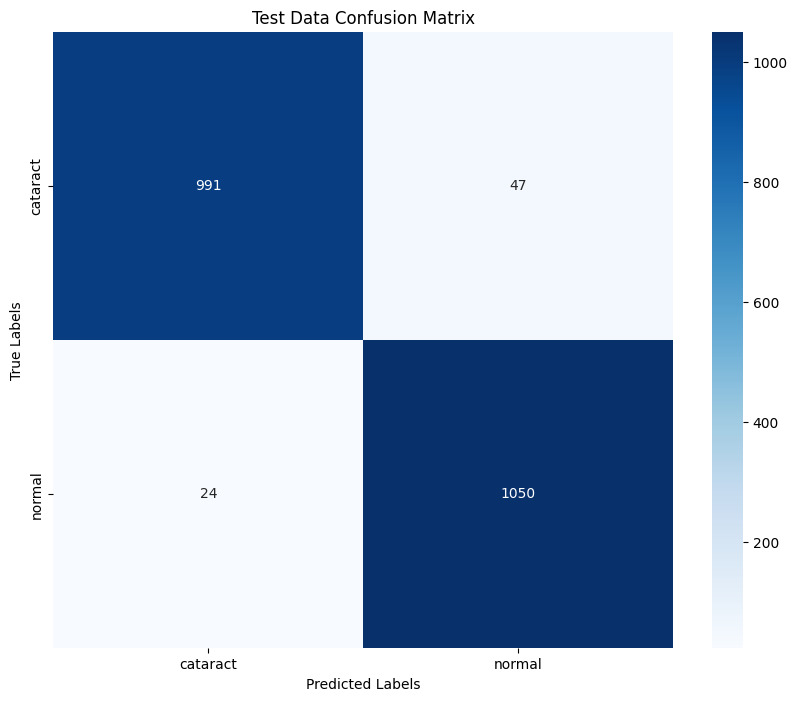

In [17]:
# Data testing
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory='dataset2',
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Predicting the test data
Y_pred_test = model.predict(test_generator, len(test_generator))
y_pred_test = np.argmax(Y_pred_test, axis=1)

# True labels from test generator
y_true_test = test_generator.classes

# Classification report and confusion matrix
print('Classification Report')
target_names = list(test_generator.class_indices.keys())
print(classification_report(y_true_test, y_pred_test, target_names=target_names))

print('Confusion Matrix')
conf_matrix_test = confusion_matrix(y_true_test, y_pred_test)
print(conf_matrix_test)

# Plotting the confusion matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Test Data Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

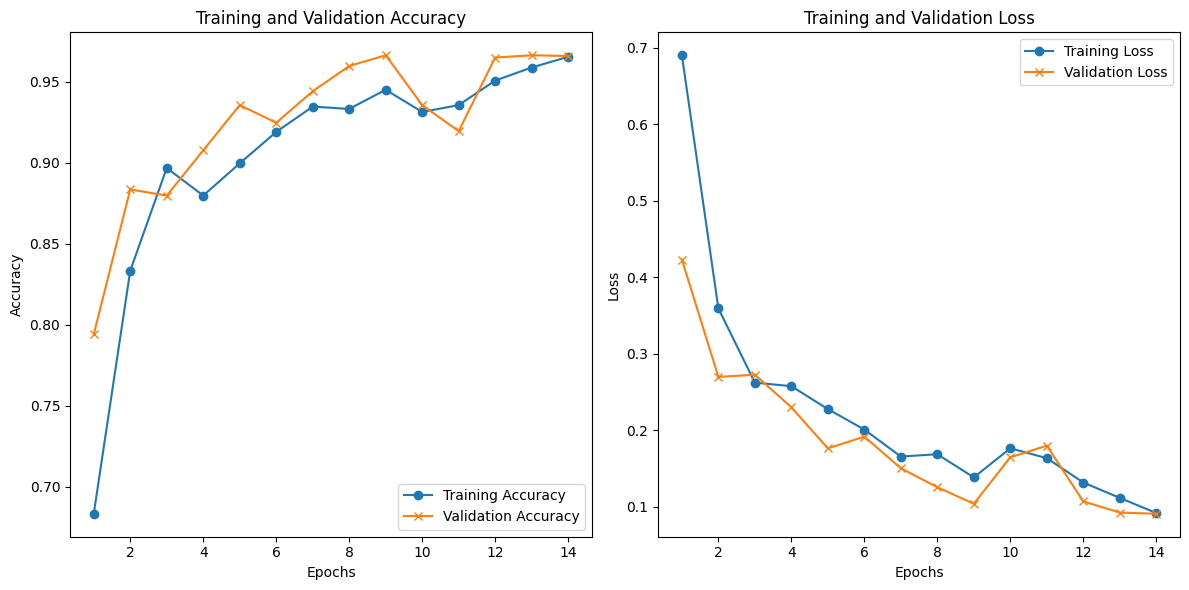

In [18]:
# Plotting accuracy and loss for training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='x')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()